## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction

- Accept the kaggle policy and download the data from here https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data
- For the first model building, we'll only use the 2019-Nov csv data (which is still around ~2gb)

In [1]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
#import squarify
import matplotlib.dates as dates
from datetime import datetime

%matplotlib inline

In [18]:
# fill this in with your path (absolute path works as well)
path_to_file = "2019-Nov.csv"
df = pd.read_csv(path_to_file, nrows=2_000_000)

Let's do some exploratory analysis on the data!

In [19]:
# take a quick look of the data
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283


In [20]:
df.tail(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1999998,2019-11-02 09:40:42 UTC,view,22400036,2053013554474254687,electronics.audio.microphone,hoco,25.71,566726454,b0f7ab51-cf1c-49e9-a7ee-2bb40c8d48d0
1999999,2019-11-02 09:40:42 UTC,view,8500459,2053013552259662037,NaN,NaN,226.49,566727531,f273ae70-3a7a-486b-a238-984aa622e537


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 137.3+ MB


In [22]:
df.shape

(2000000, 9)

In [23]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site?

In [24]:
visitor = df['user_id'].nunique()
print ("visitors: {}".format(visitor))

visitors: 300008


# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic, and construct the plots for visualization. 

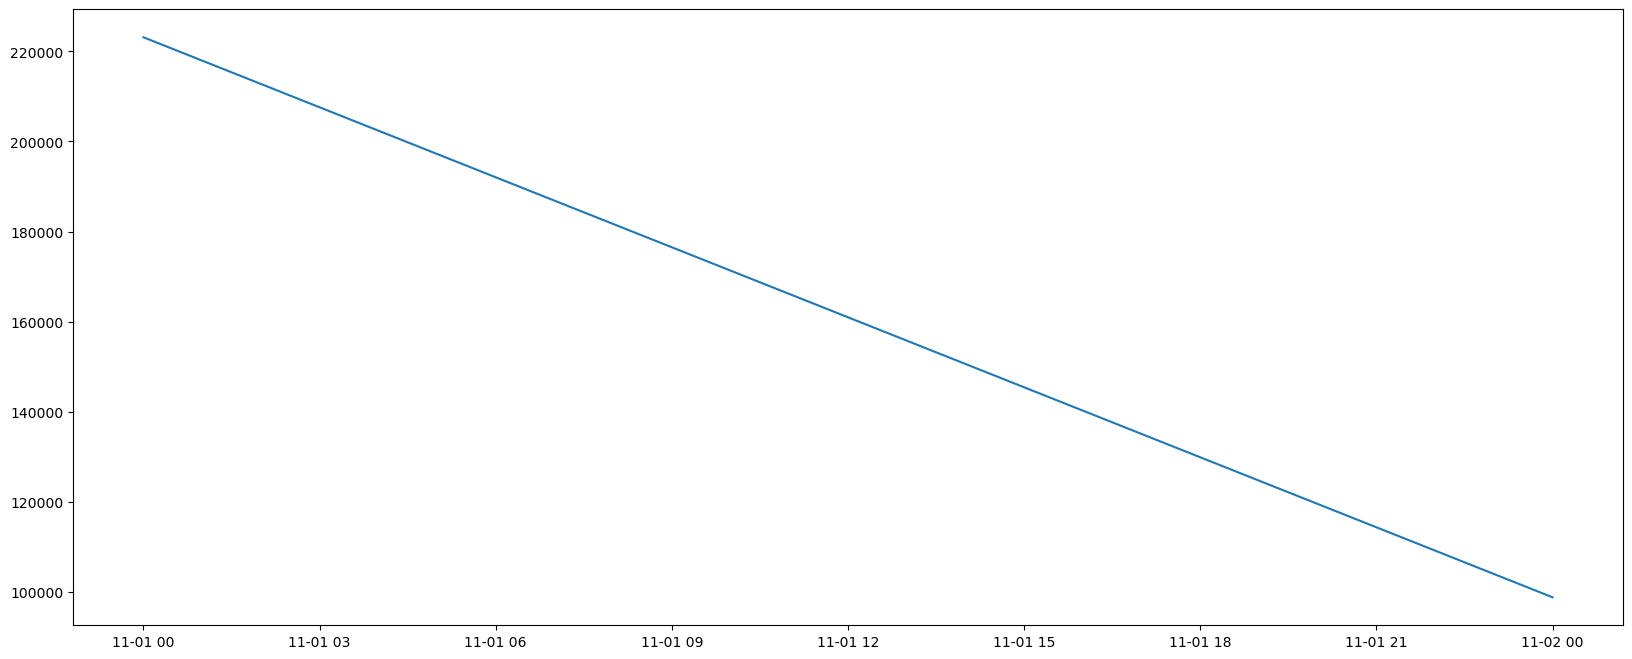

In [25]:
d = df.loc[:, ['event_time','user_id']]
d['event_time'] = d['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count'])\
    .sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20, 8)

plt.plot(x,y)
plt.show()

### By Category and Product
With which category do customers interact the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

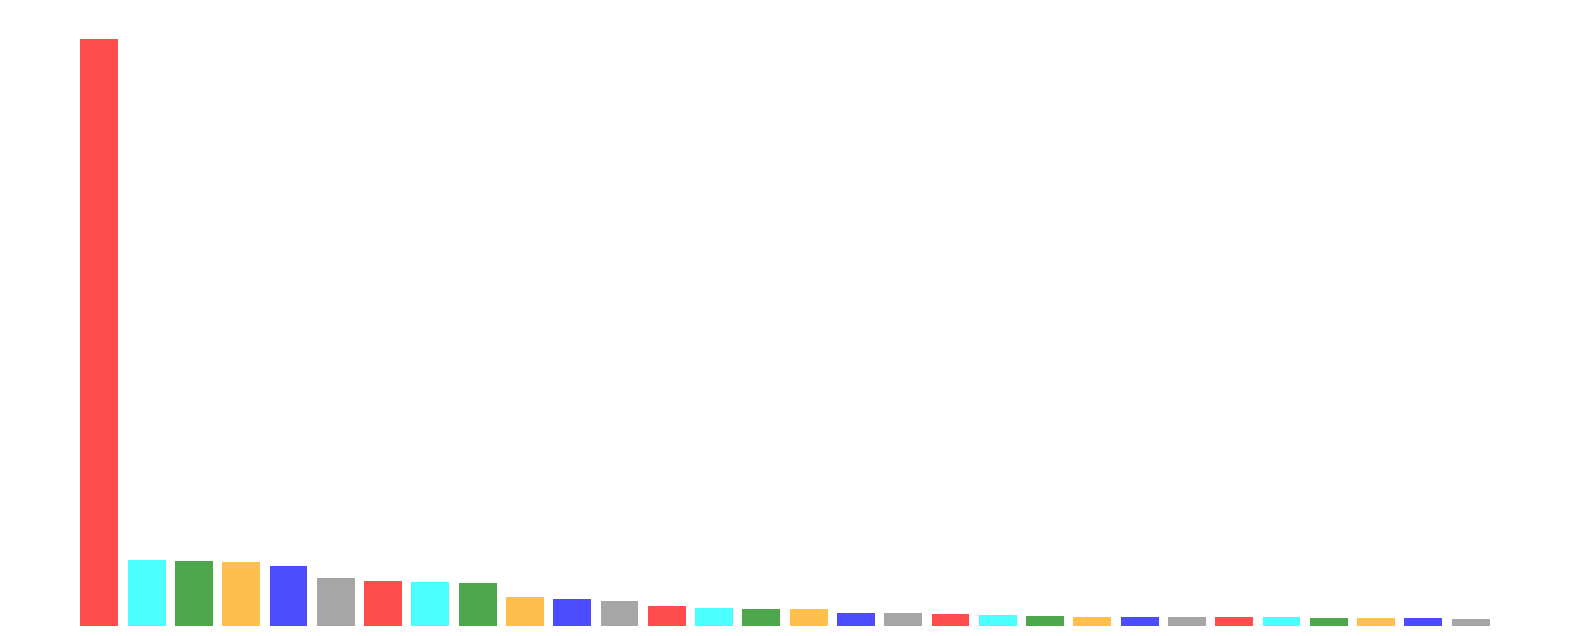

In [26]:
max_category_num = 30
top_category = df.loc[:, 'category_code'].value_counts()[:max_category_num].sort_values(ascending=False)
plt.bar(height=top_category, x=top_category.index.array,
              color=["red","cyan","green","orange","blue","grey"], alpha=0.7)
plt.axis('off')
plt.show()

## When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [29]:
# your code
df[df['event_type'] == 'purchase']['category_code'].value_counts()


electronics.smartphone         14556
electronics.audio.headphone     1242
electronics.video.tv             876
electronics.clocks               731
appliances.kitchen.washer        639
                               ...  
construction.tools.light           1
sport.tennis                       1
apparel.sock                       1
accessories.umbrella               1
auto.accessories.winch             1
Name: category_code, Length: 108, dtype: int64

## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [34]:
# your code
df.groupby('brand').value_counts()


brand       event_time               event_type  product_id  category_id          category_code                  price    user_id    user_session                        
a-elita     2019-11-01 09:22:11 UTC  view        32900095    2055156924407612189  accessories.bag                73.28    513255079  6de6b8fc-58aa-4272-84e9-e616dd21eff1    1
            2019-11-02 08:29:30 UTC  view        32900083    2055156924407612189  accessories.bag                8.49     550607965  f3b9eade-e6db-49cf-8b3d-8acf4d58c12a    1
aardwolf    2019-11-02 02:38:36 UTC  view        30901103    2053013554004492609  computers.components.cooler    79.15    560959712  9d5757b3-f041-4e2d-aa06-2774750a8eba    1
accumaster  2019-11-02 06:07:17 UTC  view        27600466    2053013560061067945  country_yard.lawn_mower        97.49    557027642  8d63cde8-0dd0-4113-9515-eae8b6b72048    1
acd         2019-11-01 05:34:53 UTC  view        30901089    2053013554004492609  computers.components.cooler    5.53     51363228

In [35]:
del d # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `activity_count`: number of activity in that session
- `is_purchased`: whether the put in cart item is purchased, this will be our categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [37]:
# your code
# first just eliminate the records where event_type = "view"

#cart_purchase_users_all_activity = 

In [ ]:
# now we get the number of activities by user session

activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [ ]:
df_targets = cart_purchase_users_all_activity.copy()

In [ ]:
# Change the event_time to a timestamp

df_targets['timestamp'] = None

In [ ]:
# Use pandas.dt.dayofweek to get the day of the week

In [ ]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')

In [ ]:
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)

In [ ]:
df_targets.head()

## Save new data structure for modeling

In [ ]:
df_targets.to_csv('training_data.csv')

In [ ]:
df_targets.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [ ]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]

In [ ]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

In [ ]:
n_samples = 500000
is_purchase_downsampled = resample(is_purcahase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purcahase_set_downsampled = resample(not_purcahase_set,
                                replace = False,
                                n_samples = n_samples,
                                random_state = 27)

In [ ]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled['is_purchased'].value_counts()

In [ ]:
features = downsampled.loc[:,
                           ['brand', 'price', 'weekday', 'category_level1',
                            'category_level2', 'activity_count']]

## Encode categorical variables

In [ ]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'weekday'].copy())
features.loc[:,'category_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_level1'].copy())
features.loc[:,'category_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_level2'].copy())

is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

In [ ]:
print(list(features.columns))

## Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

## Train the model
Choose learning rate of 0.1 on XGBClassifier.

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

## Feature importance
Show feature importance using plot_importance

In [ ]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()